In [138]:
import cv2 
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch import nn, optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split

torch.set_default_tensor_type('torch.DoubleTensor')

In [135]:
class LeNet(nn.Module):
	def __init__(self):
		super(LeNet, self).__init__()
		self.conv1 = nn.Conv2d(3, 6, (5,5), padding=2)
		self.conv2 = nn.Conv2d(6, 16, (5,5))
		self.fc1   = nn.Linear(16*5*5, 120)
		self.fc2   = nn.Linear(120, 84)
		self.fc3   = nn.Linear(84, 2)
	def forward(self, x):
		x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
		x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
		x = x.view(-1, self.num_flat_features(x))
		x = F.relu(self.fc1(x))
		x = F.relu(self.fc2(x))
		x = self.fc3(x)
		return x
	def num_flat_features(self, x):
		size = x.size()[1:]
		num_features = 1
		for s in size:
			num_features *= s
		return num_features

use_gpu = torch.cuda.is_available()
if use_gpu:
	net = net.cuda()
	print ('USE GPU')
else:
	print ('USE CPU')


USE CPU


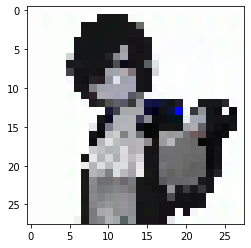

In [121]:
image = cv2.imread(os.path.join("C:/Users/ericp/Desktop/pixiv/data/normal/", "72390335_p0_square1200.jpg"))
image = cv2.resize(image, (28,28)) 
plt.imshow(image)

In [122]:
images_n = []
for file in os.listdir("C:/Users/ericp/Desktop/pixiv/data/normal"):
    image = cv2.imread(os.path.join("C:/Users/ericp/Desktop/pixiv/data/normal", file))
    image = cv2.resize(image, (28, 28)) 
    #blue_image = image[:,:,0]
    #green_image = image[:,:,1]
    #red_image = image[:,:,2]
    images_n.append(list((np.transpose(image)/255.0).astype('float64')))
images_n = np.array(images_n)
print(images_n.shape)

(7207, 3, 28, 28)


In [123]:
images_r = []
for file in os.listdir("C:/Users/ericp/Desktop/pixiv/data/r18"):
    image = cv2.imread(os.path.join("C:/Users/ericp/Desktop/pixiv/data/r18", file))
    image = cv2.resize(image, (28, 28)) 
    #blue_image = image[:,:,0]
    #green_image = image[:,:,1]
    #red_image = image[:,:,2]
    images_r.append(list((np.transpose(image)/255.0).astype('float64')))
images_r = np.array(images_r)
print(images_r.shape)

(3687, 3, 28, 28)


In [148]:
X_train, X_test, y_train, y_test = train_test_split(
    np.concatenate((images_n, images_r), axis = 0), 
    np.concatenate((np.zeros(len(images_n)), np.ones(len(images_r))), axis = 0), 
    test_size=0.25)

In [145]:
class OurDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform
        
    def __len__(self):
        return len(self.X);
    
    def __getitem__(self, idx):
        item = torch.from_numpy(self.X[idx])
        label = torch.tensor(self.Y[idx], dtype=torch.long)  
        
        if self.transform:
            item = self.transform(item)
        
        return (item, label)

In [149]:
trainData = OurDataset(X_train,  y_train)
testData = OurDataset(X_test,  y_test)
trainLoader = DataLoader(trainData, batch_size=128, shuffle=True, num_workers=0)
testLoader = DataLoader(testData, batch_size=128, shuffle=False, num_workers=0)

In [150]:
net = LeNet()

optimizer = optim.SGD(net.parameters(), lr=0.1, weight_decay=0)
optimizer.zero_grad()

criterion = nn.CrossEntropyLoss()

def test(net, testLoader):
    net.eval()
    correct = 0
    with torch.no_grad():
        for (data,target) in testLoader:
            output = net(data)
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            
        print("Test Accuracy: %f" % (100.*correct/len(testLoader.dataset)))

test(net, testLoader)

for epoch in range(10):
    net.train()
    for batch_idx, (data, target) in enumerate(trainLoader):
        pred = net(data)
        
        loss = criterion(pred, target)
        loss.backward()
        gn = 0
        for f in net.parameters():
            gn = gn + torch.norm(f.grad)
        print("E: %d; B: %d; Loss: %f; ||g||: %f" % (epoch, batch_idx, loss, gn))
        optimizer.step()
        optimizer.zero_grad()
    
    test(net, testLoader)

Test Accuracy: 66.372981
E: 0; B: 0; Loss: 0.683961; ||g||: 0.948228
E: 0; B: 1; Loss: 0.673361; ||g||: 0.738079
E: 0; B: 2; Loss: 0.673667; ||g||: 0.439392
E: 0; B: 3; Loss: 0.646319; ||g||: 1.045297
E: 0; B: 4; Loss: 0.671190; ||g||: 0.151824
E: 0; B: 5; Loss: 0.645033; ||g||: 0.600022
E: 0; B: 6; Loss: 0.655073; ||g||: 0.201516
E: 0; B: 7; Loss: 0.660498; ||g||: 0.150257
E: 0; B: 8; Loss: 0.636301; ||g||: 0.553638
E: 0; B: 9; Loss: 0.597642; ||g||: 1.024245
E: 0; B: 10; Loss: 0.668632; ||g||: 0.934072
E: 0; B: 11; Loss: 0.651777; ||g||: 0.160637
E: 0; B: 12; Loss: 0.624323; ||g||: 0.533689
E: 0; B: 13; Loss: 0.654297; ||g||: 0.408061
E: 0; B: 14; Loss: 0.643319; ||g||: 0.131492
E: 0; B: 15; Loss: 0.621053; ||g||: 0.497283
E: 0; B: 16; Loss: 0.603722; ||g||: 0.508426
E: 0; B: 17; Loss: 0.674729; ||g||: 1.038698
E: 0; B: 18; Loss: 0.665500; ||g||: 0.415221
E: 0; B: 19; Loss: 0.645671; ||g||: 0.223826
E: 0; B: 20; Loss: 0.632740; ||g||: 0.387647
E: 0; B: 21; Loss: 0.612027; ||g||: 0.62

KeyboardInterrupt: 